# Final Figures

This notebook will show the results of the classification in the same way as is done in our baseline study by Lei et al. (https://github.com/amarallab/transportation_network_evolution).

## Imports

In [8]:
import itertools
import math
import glob
import random
import pickle
import os
import pandas as pd
import numpy as np
import networkx as nx
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
import seaborn as sns
import matplotlib as mpl
import contextily as ctx
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore')

from datetime import date
from shapely.geometry import Point, LineString
from sklearn.preprocessing import quantile_transform
from matplotlib.patches import Patch
from scipy.stats import ks_2samp, combine_pvalues

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import make_scorer, balanced_accuracy_score, f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from joblib import Parallel, delayed

In [2]:
import warnings
warnings.simplefilter(action='ignore')

In [3]:
import sys

sys.path.append('/Users/merelkamper/Documents/MSc Data Science/Thesis/transportation_network_evolution-master/src')
from plot_style import *
stdrcparams(usetex=False)

In [6]:
# Load dataset with the features per trajectory per month
data_path = '/Users/merelkamper/Documents/MSc Data Science/Thesis/MSc_Thesis_code/features/monthly_features_per_trajectory.csv'
data = pd.read_csv(data_path)

# Convert YearMonth to datetime format to extract year and month
data['YearMonth'] = pd.to_datetime(data['YearMonth'].astype(str))
data['YEAR'] = data['YearMonth'].dt.year
data['MONTH'] = data['YearMonth'].dt.month

# Define the directory containing the result from all classifiers files
results_dir = '/Users/merelkamper/Documents/MSc Data Science/Thesis/MSc_thesis_code/results_classifiers/'


In [4]:
feature_name_map = {
    'SO': 'Sorensen',
    'CN': 'Common Neighbor',
    'JA': 'Jaccard',
    'SA': 'Salton',
    'HPI': 'Hub Promoted',
    'HDI': 'Hub Depressed',
    'LHNI': 'Leicht Holme Newman',
    'PA': 'Preferential Attachment',
    'AA': 'Adamic Adar',
    'RA': 'Resource Allocation',
    'LPI': 'Local Path',
    'weighted_SO': 'Weighted Sorensen',
    'weighted_CN': 'Weighted Common Neighbor',
    'weighted_JA': 'Weighted Jaccard',
    'weighted_SA': 'Weighted Salton',
    'weighted_HPI': 'Weighted Hub Promoted',
    'weighted_HDI': 'Weighted Hub Depressed',
    'weighted_LHNI': 'Weighted Leicht Holme Newman',
    'weighted_PA': 'Weighted Preferential Attachment',
    'weighted_AA': 'Weighted Adamic Adar',
    'weighted_RA': 'Weighted Resource Allocation',
    'weighted_LPI': 'Weighted Local Path',
    'source_closeness': 'Source Closeness',
    'target_closeness': 'Target Closeness',
    'source_degree': 'Source Degree',
    'target_degree': 'Target Degree',
    'source_strength': 'Source Strength',
    'target_strength': 'Target Strength'
}

## General Figures

### Graph on Map

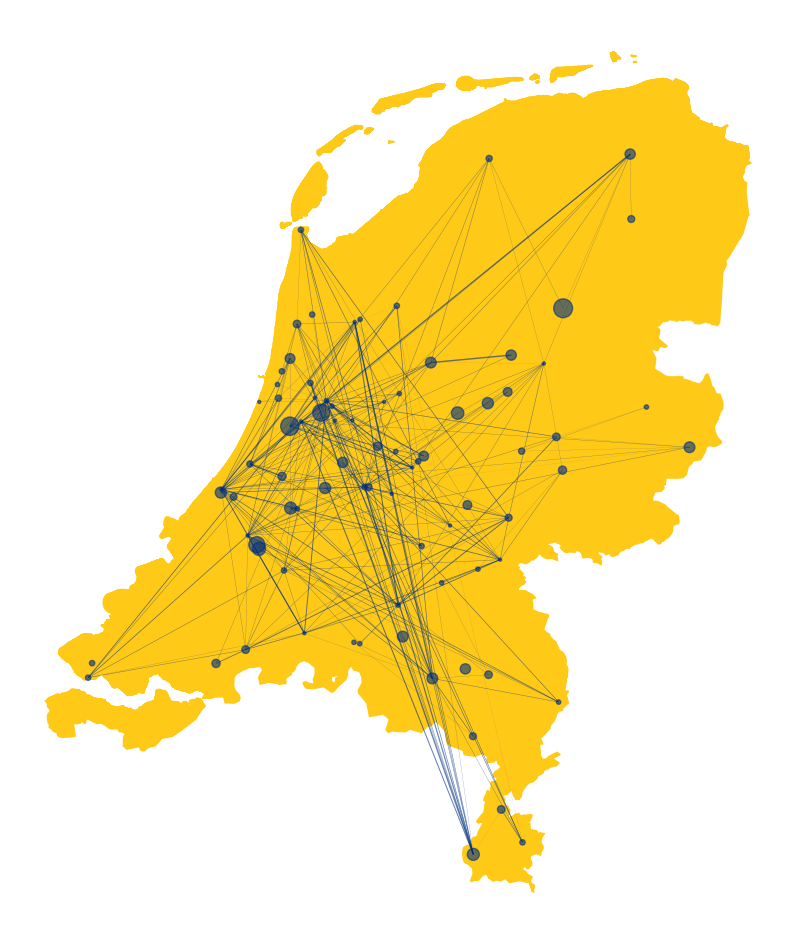

In [9]:
# Map for disruoted lines
# Function to visualize the graph on a custom map of the Netherlands
def visualize_graph_on_custom_map(graph, station_coords, shapefile_path,title="Graph on Map"):
    # Load the shapefile
    gdf_netherlands = gpd.read_file(shapefile_path)
    
    # Filter out unused stations
    used_stations = set(graph.nodes())
    filtered_coords = {station: coords for station, coords in station_coords.items() if station in used_stations}
    
    # Create a GeoDataFrame for stations
    gdf_nodes = gpd.GeoDataFrame(
        {'Station': list(filtered_coords.keys())},
        geometry=[Point(filtered_coords[station]['geo_lng'], filtered_coords[station]['geo_lat']) for station in filtered_coords],
        crs="EPSG:4326"
    )

    # Convert to the same CRS as the shapefile
    gdf_nodes = gdf_nodes.to_crs(gdf_netherlands.crs)
    
    # Create a GeoDataFrame for edges
    edge_list = []
    for u, v, data in graph.edges(data=True):
        if u in filtered_coords and v in filtered_coords:
            point_u = Point(filtered_coords[u]['geo_lng'], filtered_coords[u]['geo_lat'])
            point_v = Point(filtered_coords[v]['geo_lng'], filtered_coords[v]['geo_lat'])
            line = LineString([point_u, point_v])
            edge_list.append({'geometry': line, 'weight': data['Proportion delayed']})
    
    gdf_edges = gpd.GeoDataFrame(edge_list, crs="EPSG:4326")
    gdf_edges = gdf_edges.to_crs(gdf_netherlands.crs)

    fig, ax = plt.subplots(figsize=(12, 12))

    # Plot the shapefile (using NS colors from: https://www.ns.nl/platform/fundamentals/colours.html)
    gdf_netherlands.plot(ax=ax, color='#FFC917', edgecolor='#FFC917')
    
    # Calculate node sizes based on degree
    node_sizes = [graph.degree(node) * 5 for node in graph.nodes()]
    
    # Plot the stations
    gdf_nodes.plot(ax=ax, color='#003082', markersize=node_sizes, alpha=0.6)

    # Plot the edges with weight
    gdf_edges.plot(ax=ax, linewidth=gdf_edges['weight'], alpha=0.6, edgecolor='#003082')
        
    # Remove axis ticks and labels
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    
    # Remove the border
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.show()

# Load station coordinates
station_coords_path = '/Users/merelkamper/Documents/MSc Data Science/Thesis/MSc_Thesis_code/stations_data/stations-2023.csv'
station_coords = pd.read_csv(station_coords_path, delimiter=";")

# Filter to only include stations in the Netherlands
station_coords = station_coords[station_coords['country'] == 'NL']

# Ensure coordinates are numeric
station_coords['geo_lat'] = pd.to_numeric(station_coords['geo_lat'], errors='coerce')
station_coords['geo_lng'] = pd.to_numeric(station_coords['geo_lng'], errors='coerce')

# Convert station coordinates to a dictionary
station_coords_dict = station_coords.set_index('name_long')[['geo_lat', 'geo_lng']].T.to_dict()

# Filter the data for a specific month
year = 2024
month = 4
graph_data = data[(data['YEAR'] == year) & (data['MONTH'] == month)]

# Filter stations that are used in the edges
used_stations = set(graph_data['source']).union(set(graph_data['target']))
station_coords_dict = {station: station_coords_dict[station] for station in used_stations if station in station_coords_dict}

# Create edges GeoDataFrame
edges = []
for _, row in graph_data.iterrows():
    source = row['source']
    target = row['target']
    rides_planned = row['Proportion delayed']
    
    if source in station_coords_dict and target in station_coords_dict:
        source_coords = Point(station_coords_dict[source]['geo_lng'], station_coords_dict[source]['geo_lat'])
        target_coords = Point(station_coords_dict[target]['geo_lng'], station_coords_dict[target]['geo_lat'])
        line = LineString([source_coords, target_coords])
        edges.append({'geometry': line, 'weight': rides_planned})

gdf_edges = gpd.GeoDataFrame(edges, crs="EPSG:4326")

# Create the graph
graph = nx.from_pandas_edgelist(graph_data, 'source', 'target', edge_attr=True)

# Path to the shapefile of the Netherlands
shapefile_path = '/Users/merelkamper/Documents/MSc Data Science/Thesis/nl_shapes/NLD_adm0.shp'

# Visualize the graph on the custom map
# visualize_graph_on_custom_map(graph, station_coords_dict, shapefile_path, title=f" Proportion Train Services Delayed ({year}-{month:02d})")
visualize_graph_on_custom_map(graph, station_coords_dict, shapefile_path)


### Proportion Delayed

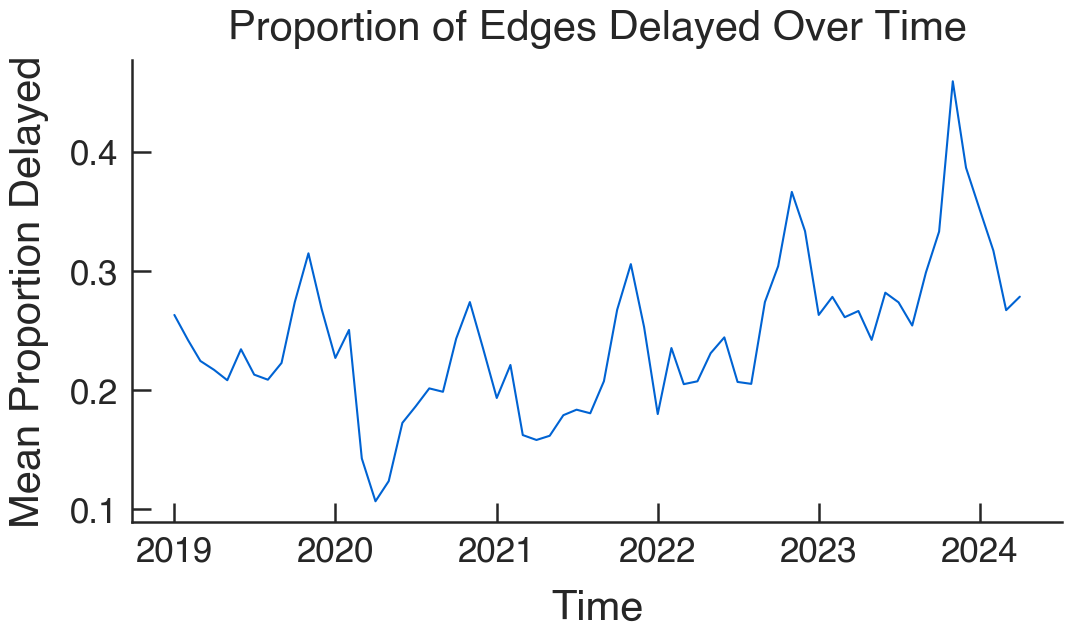

In [10]:
# PROPORTION DELAYED
# Group by 'YearMonth' and calculate the mean 'Proportion delayed' for each month
monthly_mean_delayed = data.groupby('YearMonth')['Proportion delayed'].mean().reset_index()

# Ensure data is sorted by 'YearMonth'
monthly_mean_delayed = monthly_mean_delayed.sort_values(by='YearMonth')

# Create the plot, using NS blue for the line from: https://www.ns.nl/platform/fundamentals/colours.html 
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(monthly_mean_delayed['YearMonth'], monthly_mean_delayed['Proportion delayed'], label='Proportion delayed', color='#0063D3')

# Format the x-axis to show only the years
ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y'))
ax.xaxis.set_major_locator(plt.matplotlib.dates.YearLocator())

# Remove the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# # Remove the top and right ticks
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

# Add labels and title
ax.set_xlabel('Time')
ax.set_ylabel('Mean Proportion Delayed')
ax.set_title('Proportion of Edges Delayed Over Time')
plt.show()

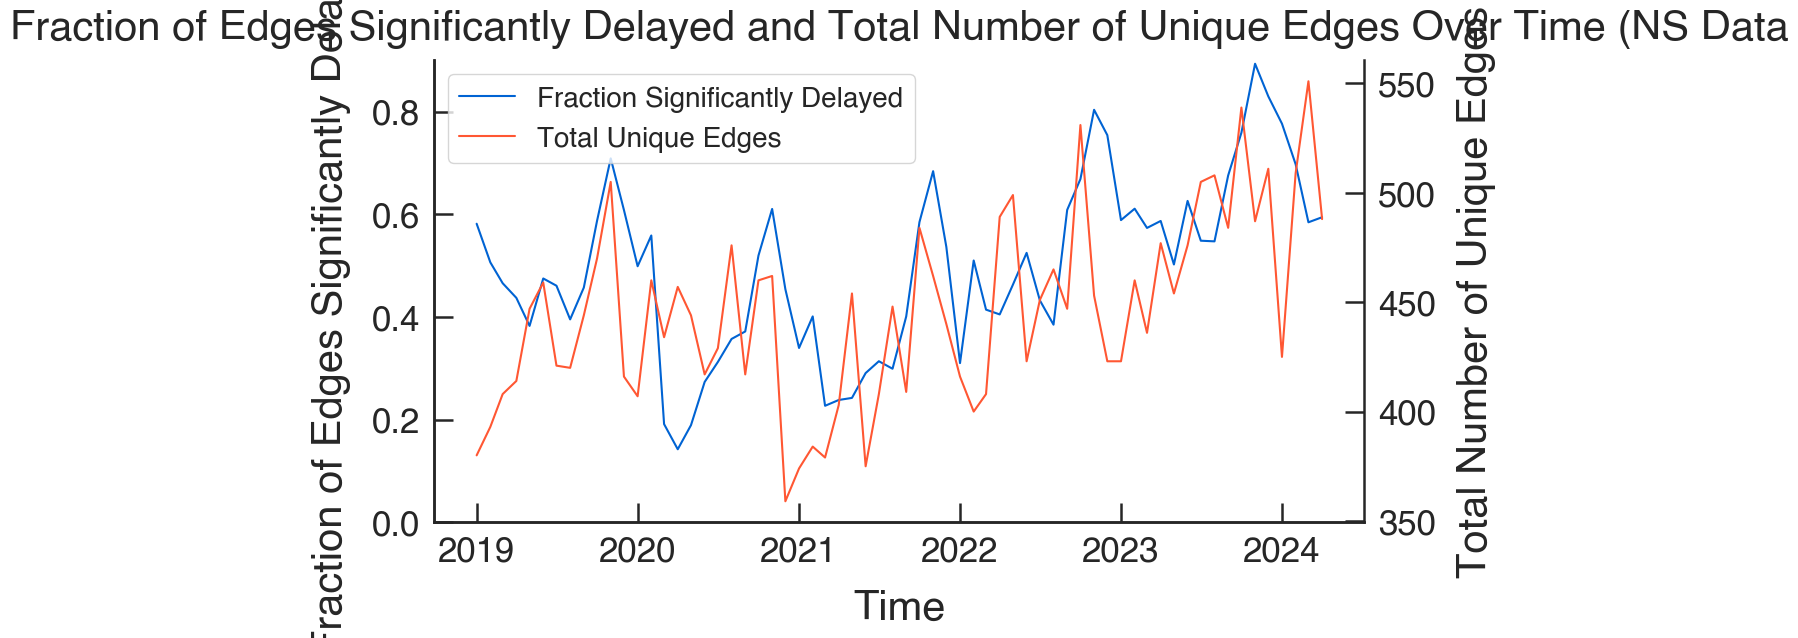

In [11]:
# Create a plot for fraction removed
monthly_mean_sig_delayed = data.groupby('YearMonth')['Significant Delay'].mean().reset_index()

# Calculate the total number of edges per month
monthly_total_edges = data.groupby('YearMonth').size().reset_index(name='Total Edges')

# Merge the two dataframes on 'YearMonth' to ensure they align correctly
monthly_data = pd.merge(monthly_mean_sig_delayed, monthly_total_edges, on='YearMonth')

# Plotting the results
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the fraction of edges significantly delayed
ax.plot(monthly_data['YearMonth'], monthly_data['Significant Delay'], label='Fraction Significantly Delayed', color='#0063D3')

# Plot the total number of edges on a secondary y-axis
ax2 = ax.twinx()
ax2.plot(monthly_data['YearMonth'], monthly_data['Total Edges'], label='Total Unique Edges', color='#FF5733')

# Format the x-axis to show only the years
ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y'))
ax.xaxis.set_major_locator(plt.matplotlib.dates.YearLocator())

# Remove the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)

# Remove the top and right ticks
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax2.yaxis.set_ticks_position('right')

# Set y-axis limits for the fraction significantly delayed
ax.set_ylim(0, 0.9)

# Add labels and title
ax.set_xlabel('Time')
ax.set_ylabel('Fraction of Edges Significantly Delayed')
ax2.set_ylabel('Total Number of Unique Edges')
ax.set_title('Fraction of Edges Significantly Delayed and Total Number of Unique Edges Over Time (NS Data')

# Combine legends from both axes
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines + lines2, labels + labels2, loc='upper left')

plt.show()

In [12]:
# MEAN CALCULATION
overall_mean_proportion_delayed = data['Proportion delayed'].mean()
print(f"Overall mean proportion of delayed edges: {overall_mean_proportion_delayed:.4f}")

Overall mean proportion of delayed edges: 0.2453


### Feature Evaluation

In [13]:
# Load data
data_path = '/Users/merelkamper/Documents/MSc Data Science/Thesis/MSc_thesis_code/features/monthly_features_per_trajectory.csv'
data = pd.read_csv(data_path)

# Convert 'YearMonth' to datetime if not already done
data['YearMonth'] = pd.to_datetime(data['YearMonth'], format='%Y-%m')

# Define the feature sets
feature_sets = {
    'TF': ['CN', 'SA', 'JA', 'SO', 'HPI', 'HDI', 'LHNI', 'PA', 'AA', 'RA', 'LPI'],
    'WTF': ['weighted_CN', 'weighted_SA', 'weighted_JA', 'weighted_SO', 'weighted_HPI', 'weighted_HDI', 'weighted_LHNI', 'weighted_PA', 'weighted_AA', 'weighted_RA', 'weighted_LPI'],
    'Demographic and Spatial': ['distance', 'population_source', 'population_target', 'gravitational_index'],
    'Centrality measures': ['source_betweenness', 'target_betweenness', 'source_closeness', 'target_closeness', 'source_degree', 'target_degree']
}

# Combine all feature sets into a single list
all_features = [feature for feature_list in feature_sets.values() for feature in feature_list]

# Initialize lists to store results
all_importances = []
all_months = []

# Loop over each month in the data
for year in range(2019, 2025):
    for month in range(1, 13):
        # Filter data for the specific month
        month_data = data[(data['YearMonth'].dt.year == year) & (data['YearMonth'].dt.month == month)]
        
        if month_data.empty:
            continue
        
        # Separate features and target
        X = month_data[all_features]
        y = month_data['Significant Delay'].astype(int)

        # Apply quantile transformation to features
        X_transformed = quantile_transform(X, n_quantiles=10, output_distribution='uniform')

        # Check if the month has enough data to train the model
        if len(np.unique(y)) < 2:  # At least two classes are needed
            continue

        # Apply SMOTE to handle imbalance
        smote = SMOTE(sampling_strategy='auto', random_state=42)
        X_res, y_res = smote.fit_resample(X_transformed, y)

        # Train Gradient Boosting Classifier
        classifier = GradientBoostingClassifier(random_state=42)
        classifier.fit(X_res, y_res)

        # Get feature importances
        feature_importances = classifier.feature_importances_
        
        # Store results
        all_importances.append(feature_importances)
        all_months.append(f"{year}-{month:02d}")

# Convert results to DataFrame
importances_df = pd.DataFrame(all_importances, columns=all_features)
importances_df['Month'] = all_months

# Melt the DataFrame for easier plotting with seaborn
melted_df = importances_df.melt(id_vars=['Month'], value_vars=all_features, var_name='Feature', value_name='Importance')

# Pivot the DataFrame to get features as rows and months as columns
pivot_df = melted_df.pivot(index='Feature', columns='Month', values='Importance')

# Reorder the rows to match the original feature order
pivot_df = pivot_df.loc[all_features]

# Extract unique years from the Month column for labeling
unique_years = sorted(set(pivot_df.columns.str[:4]))

# Create a heatmap
plt.figure(figsize=(20, 15))
sns.heatmap(pivot_df, cmap='YlGnBu', linewidths=.5)
plt.xticks(rotation=45, ha='right', va='top', rotation_mode='anchor')
plt.yticks(rotation=0)
plt.xlabel('Month')
plt.ylabel('Features')
plt.title('Feature Importances per Month using Gradient Boosting Classifier')
plt.show()

KeyError: "['source_betweenness', 'target_betweenness'] not in index"

## Simultaneous Testing

In [6]:
df_simultaneousClassification_BTF = pd.read_csv('/Users/merelkamper/Documents/MSc Data Science/Thesis/MSC_Thesis_code/new_results/NS_Classification_BTF_simultaneous.csv')[['YearMonth','Significant Delay','simultaneous_pred','simultaneous_null']]
df_simultaneousClassification_WTF = pd.read_csv('/Users/merelkamper/Documents/MSc Data Science/Thesis/MSC_Thesis_code/new_results/NS_Classification_WTF_simultaneous.csv')[['YearMonth','Significant Delay','simultaneous_pred','simultaneous_null']]
df_simultaneousClassification_NCM = pd.read_csv('/Users/merelkamper/Documents/MSc Data Science/Thesis/MSC_Thesis_code/new_results/NS_Classification_NCM_simultaneous.csv')[['YearMonth','Significant Delay','simultaneous_pred','simultaneous_null']]

In [7]:
df_simultaneousClassification = {'Unweighted Topological Features': df_simultaneousClassification_BTF,
                                 'Weighted Topological Features': df_simultaneousClassification_WTF,
                                 'Node Centrality Measures': df_simultaneousClassification_NCM
                                }

In [61]:
def pure_plot_confusion_matrix(cm, ax = None):
    classes = ['Not Sig. Delayed','Sig. Delayed']
    sns.heatmap(cm, square = True, annot= True, cbar = False, cmap=plt.cm.Blues,ax = ax,annot_kws={"fontsize":25})
    ax.set_ylim(0,2)
    ax.tick_params( bottom=False, right=False,left=False, labeltop=False, labelbottom=True)
    ax.invert_yaxis()
    ax.set(xticks = np.arange(cm.shape[1])+0.5,
           yticks = np.arange(cm.shape[0])+0.25,
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           ylabel = 'True label',
           xlabel = 'Predicted label') 

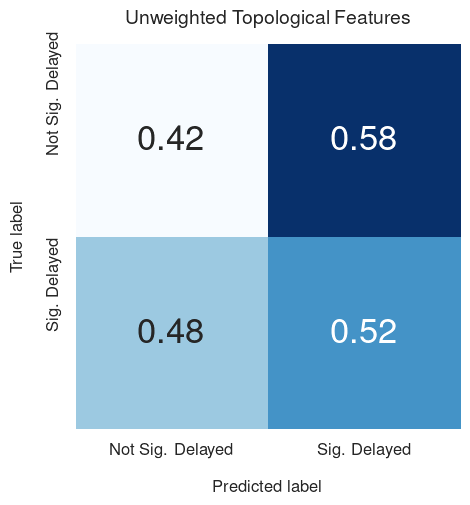

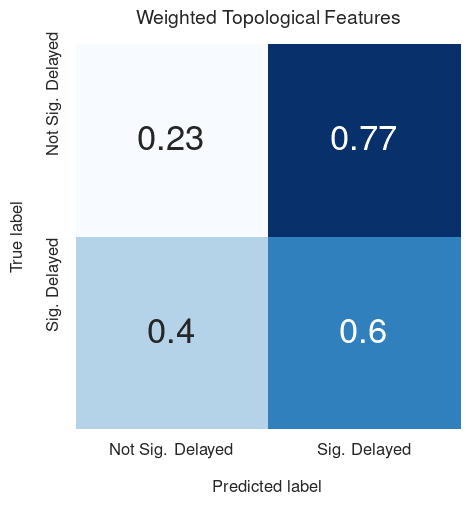

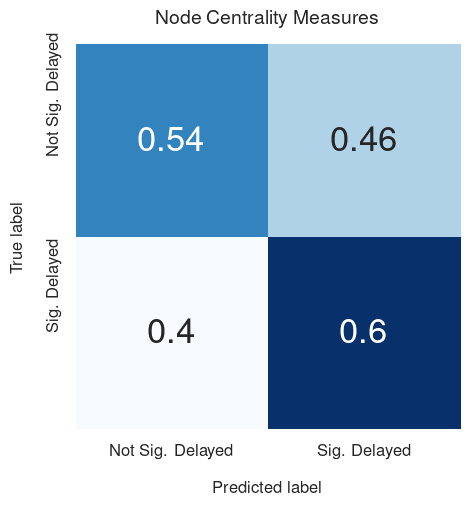

In [145]:
year = '2024-01'
for name,df in df_simultaneousClassification.items():
    # Convert 'Removed' column from boolean to integers (True/False -> 1/0) [ADDED THIS BECAUSE OF ERROR]
    df['Significant Delay'] = df['Significant Delay'].astype(int)

    y_test, y_predict = df[df['YearMonth']==year][['Significant Delay','simultaneous_pred']].values.T
    cm = confusion_matrix(y_test, y_predict)
    cm = cm.astype('float') / cm.sum(axis = 1)[:,None]
    fig,ax = plt.subplots(figsize=(5,5))
    plt.title(f"{name}", fontsize=14)
    pure_plot_confusion_matrix(cm, ax=ax)
    plt.show()

In [55]:
from datetime import datetime,date

# Assuming df_simultaneousClassification is already defined
year_list = df_simultaneousClassification_BTF.YearMonth.unique()
balanced_acc = defaultdict(list)

for name, df in df_simultaneousClassification.items():
    for year in year_list:
        period_year = pd.Period(year, freq='M')
        if period_year > pd.Period('2019-01', freq='M'):
            continue
        y_test, y_predict, y_null = df[df.YearMonth == year][['Significant Delay', 'simultaneous_pred', 'simultaneous_null']].values.T
        balanced_acc['Balanced Acc'].append(balanced_accuracy_score(y_test, y_predict))
        balanced_acc['Balanced Acc Null'].append(balanced_accuracy_score(y_test, y_null))
        balanced_acc['Model'].append(name)

In [24]:
df = pd.DataFrame(balanced_acc)
df = df.groupby('Model').mean()
df

,Balanced Acc,Balanced Acc Null
Model,,
Node Centrality Measures,0.636225,0.439407
Unweighted Topological Features,0.604185,0.385135
Weighted Topological Features,0.606582,0.544464


### Results from all classifiers 

Here we will show the results from running 1b_Classification.py that are in folder results_classifiers.

In [ ]:
# Function to extract metrics for simultaneous testing
def extract_simultaneous_metrics(results_dir):
    results = []
    for file_name in os.listdir(results_dir):
        if file_name.endswith('_results.csv') and 'nonsimultaneous' not in file_name:
            # Split the file name correctly to get the classifier name and feature set
            classifier_name, feature_set = file_name.replace('_results.csv', '').rsplit('_', 1)
            file_path = os.path.join(results_dir, file_name)
            df = pd.read_csv(file_path)

            # Check if required columns exist
            pred_column = f'{classifier_name}_{feature_set}_pred'
            proba_column = f'{classifier_name}_{feature_set}_proba'
            if pred_column in df.columns and proba_column in df.columns:
                y_true = df['Significant Delay'].astype(int).tolist()
                y_pred = df[pred_column].astype(int).tolist()
                y_proba = df[proba_column].tolist()

                if len(y_true) > 0 and len(y_pred) > 0:
                    y_true = pd.Series(y_true).astype(int)
                    y_pred = pd.Series(y_pred).astype(int)
                    if y_proba and not any(np.isnan(y_proba)):
                        y_proba = pd.Series(y_proba)
                        auc = roc_auc_score(y_true, y_proba)
                    else:
                        auc = np.nan
                    
                    balanced_accuracy = balanced_accuracy_score(y_true, y_pred)
                    f1 = f1_score(y_true, y_pred)

                    results.append({
                        'Classifier': classifier_name,
                        'Feature Set': feature_set,
                        'Balanced Accuracy': balanced_accuracy,
                        'F1 Score': f1,
                        'ROC AUC': auc
                    })
                else:
                    results.append({
                        'Classifier': classifier_name,
                        'Feature Set': feature_set,
                        'Balanced Accuracy': np.nan,
                        'F1 Score': np.nan,
                        'ROC AUC': np.nan
                    })
            else:
                print(f"Pred/Proba columns not found in {file_name}")
    return pd.DataFrame(results)

# Extract the metrics for simultaneous testing
simultaneous_df = extract_simultaneous_metrics(results_dir)

# Create separate tables for each metric
simultaneous_bal_acc_df = simultaneous_df.pivot(index='Classifier', columns='Feature Set', values='Balanced Accuracy')
simultaneous_f1_df = simultaneous_df.pivot(index='Classifier', columns='Feature Set', values='F1 Score')
simultaneous_roc_auc_df = simultaneous_df.pivot(index='Classifier', columns='Feature Set', values='ROC AUC')

# Display the tables
print("Simultaneous Testing Balanced Accuracy Results:")
display(simultaneous_bal_acc_df)

print("Simultaneous Testing F1 Score Results:")
display(simultaneous_f1_df)

print("Simultaneous Testing ROC AUC Results:")
display(simultaneous_roc_auc_df)

## Non Simultaneous Testing

In [25]:
with open('/Users/merelkamper/Documents/MSc Data Science/Thesis/MSC_Thesis_code/new_results/NS_Classification_BTF_nonsimultaneous.pkl','rb') as f:    
    df_nonsimultaneousClassification_BTF = pickle.load(f)
with open('/Users/merelkamper/Documents/MSc Data Science/Thesis/MSC_Thesis_code/new_results/NS_Classification_WTF_nonsimultaneous.pkl','rb') as f:    
    df_nonsimultaneousClassification_WTF = pickle.load(f)
with open('/Users/merelkamper/Documents/MSc Data Science/Thesis/MSC_Thesis_code/new_results/NS_Classification_NCM_nonsimultaneous.pkl','rb') as f:    
    df_nonsimultaneousClassification_NCM = pickle.load(f)

In [26]:
df_nonsimultaneousClassification = {'Unweighted Topological Features': df_nonsimultaneousClassification_BTF,
                                     'Weighted Topological Features': df_nonsimultaneousClassification_WTF,
                                     'Node Centrality Measures': df_nonsimultaneousClassification_NCM}

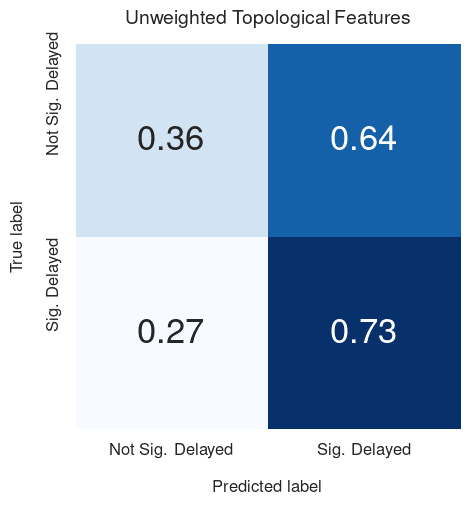

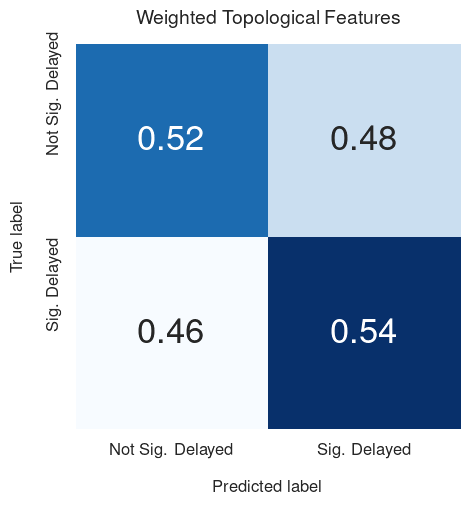

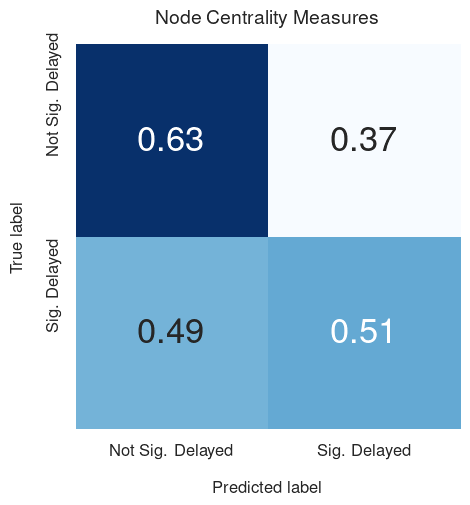

In [146]:
year0 = pd.Period('2024-01', freq='M')
year1 = pd.Period('2024-03', freq='M')

for name, df in df_nonsimultaneousClassification.items():
    for year_train, year_test, y_test, y_pred, y_null in df:
        period_year_train = pd.Period(year_train, freq='M')
        period_year_test = pd.Period(year_test, freq='M')
        
        if period_year_train == year0 and period_year_test == year1:
            break

    y_test, y_predict = y_test, y_pred
    cm = confusion_matrix(y_test, y_predict)
    cm = cm.astype('float') / cm.sum(axis=1)[:, None]
    
    fig, ax = plt.subplots(figsize=(5, 5))
    plt.title(f"{name}", fontsize=14)
    pure_plot_confusion_matrix(cm, ax=ax)
    plt.show()

In [159]:
balanced_acc_non = defaultdict(list)
for name, df in df_nonsimultaneousClassification.items():
    for year_train, year_test, y_test, y_pred, y_null in df:
        period_year_train = pd.Period(year_train, freq='M')
        period_year_test = pd.Period(year_test, freq='M')

        if period_year_train != period_year_test and period_year_train < pd.Period('2024-01', freq='M'):
            balanced_acc_non['Balanced Acc'].append(balanced_accuracy_score(y_test, y_pred))
            balanced_acc_non['Balanced Acc Null'].append(balanced_accuracy_score(y_test, y_null))
            balanced_acc_non['Model'].append(name)

# Optionally convert balanced_acc_non to a DataFrame for easier handling
balanced_acc_non_df = pd.DataFrame(balanced_acc_non)

In [160]:
# new
df = pd.DataFrame(balanced_acc_non)
df = df.groupby(['Model']).mean()
df

,Balanced Acc,Balanced Acc Null
Model,,
Node Centrality Measures,0.534914,0.500059
Unweighted Topological Features,0.517993,0.499924
Weighted Topological Features,0.531154,0.500565


### Results from all classifiers

Here we will show the results from running 1b_Classification.py that are in the results_classifiers folder.

In [ ]:
# Function to extract metrics for non-simultaneous testing
def extract_nonsimultaneous_metrics(results_dir):
    results = []
    for file_name in os.listdir(results_dir):
        if file_name.endswith('_nonsimultaneous_results.csv'):
            classifier_name, feature_set = file_name.replace('_nonsimultaneous_results.csv', '').rsplit('_', 1)
            file_path = os.path.join(results_dir, file_name)
            df = pd.read_csv(file_path)

            y_true = []
            y_pred = []
            y_proba = []
            for _, row in df.iterrows():
                y_true.extend(eval(row['TrueLabels']))
                y_pred.extend(eval(row['Predictions']))
                y_proba.extend(eval(row['Probabilities']))

            if len(y_true) > 0 and len(y_pred) > 0:
                y_true = pd.Series(y_true).astype(int)
                y_pred = pd.Series(y_pred).astype(int)
                if y_proba:
                    y_proba = pd.Series(y_proba)
                    auc = roc_auc_score(y_true, y_proba)
                else:
                    auc = np.nan
                
                balanced_accuracy = balanced_accuracy_score(y_true, y_pred)
                f1 = f1_score(y_true, y_pred)

                results.append({
                    'Classifier': classifier_name,
                    'Feature Set': feature_set,
                    'Balanced Accuracy': balanced_accuracy,
                    'F1 Score': f1,
                    'ROC AUC': auc
                })
            else:
                results.append({
                    'Classifier': classifier_name,
                    'Feature Set': feature_set,
                    'Balanced Accuracy': np.nan,
                    'F1 Score': np.nan,
                    'ROC AUC': np.nan
                })
    return pd.DataFrame(results)

# Extract the metrics for non-simultaneous testing
nonsimultaneous_df = extract_nonsimultaneous_metrics(results_dir)

# Create separate tables for each metric
nonsimultaneous_bal_acc_df = nonsimultaneous_df.pivot(index='Classifier', columns='Feature Set', values='Balanced Accuracy')
nonsimultaneous_f1_df = nonsimultaneous_df.pivot(index='Classifier', columns='Feature Set', values='F1 Score')
nonsimultaneous_roc_auc_df = nonsimultaneous_df.pivot(index='Classifier', columns='Feature Set', values='ROC AUC')

# Display the tables
print("Non-Simultaneous Testing Balanced Accuracy Results:")
display(nonsimultaneous_bal_acc_df)

print("Non-Simultaneous Testing F1 Score Results:")
display(nonsimultaneous_f1_df)

print("Non-Simultaneous Testing ROC AUC Results:")
display(nonsimultaneous_roc_auc_df)

## Metrics

In [44]:
def stdrcparams(usetex=True):
    rcparams = {
        'font.family': 'sans-serif',
        'font.sans-serif': ['Helvetica'],
        'text.usetex': usetex,
        'axes.labelsize': 12,
        'font.size': 12,
        'legend.fontsize': 12,
        'xtick.labelsize': 12,
        'ytick.labelsize': 12,
    }
    if usetex:
        rcparams['text.latex.preamble'] = r'\usepackage{amsmath}'
    mpl.rcParams.update(rcparams)
    
# Define plot dimensions
xs = 8  # width of the plot
ys = 5   # height of the plot

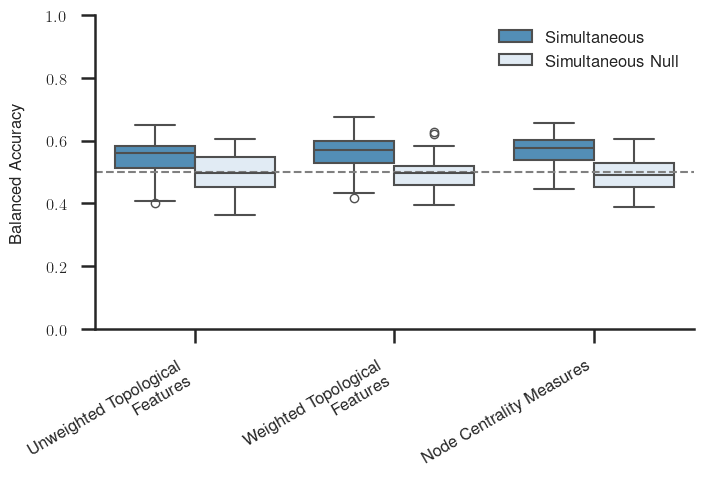

In [45]:
stdrcparams(usetex=True)
df1 = pd.DataFrame(balanced_acc)[['Model','Balanced Acc']]
df1['Test'] = 'Simultaneous'
df3 = pd.DataFrame(balanced_acc)[['Model','Balanced Acc Null']].rename(columns={'Balanced Acc Null':'Balanced Acc'})
df3['Test'] = 'Simultaneous Null'
df = pd.concat([df1,df3])
models=[ 'Unweighted Topological Features',
         'Weighted Topological Features',
         'Node Centrality Measures']
xlbls=[ 'Unweighted Topological \nFeatures',
         'Weighted Topological \nFeatures',
         'Node Centrality Measures']
df = df[df.Model.isin(models)]

fig,ax = plt.subplots(figsize=(xs*0.9,ys))
ax = sns.boxplot(x="Model", y="Balanced Acc",hue='Test',
                 palette=sns.color_palette(['#4292c6','#deebf7']),#,'#41ab5d','#e5f5e0']),
                 data=df,ax=ax,linewidth=1.5,
                 hue_order=['Simultaneous','Simultaneous Null'])#,'Non-Simultaneous','Non-Simultaneous Null'])
custom_frame(ax)
plt.ylabel('Balanced Accuracy')
plt.xlabel('')
plt.xticks(range(3),xlbls)
plt.xticks(rotation=30, ha='right')
plt.legend(frameon=False)
ax.axhline(y=0.5, linestyle = '--',color ='grey')
plt.ylim(0,1)
plt.tight_layout()
plt.show()

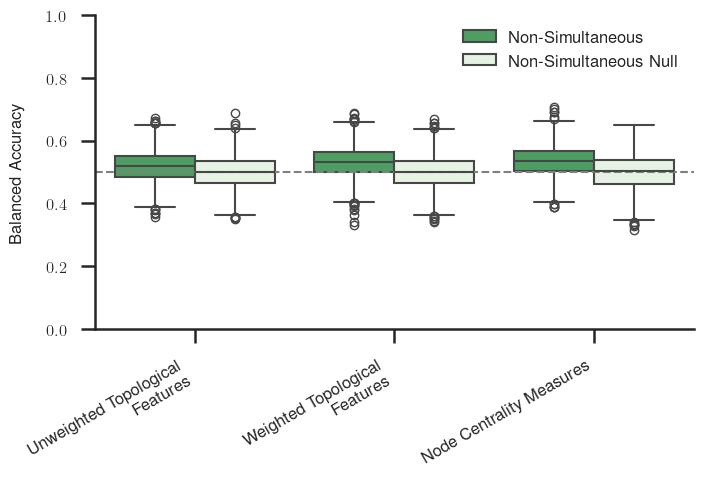

In [33]:
stdrcparams(usetex=True)
df1 = pd.DataFrame(balanced_acc)[['Model','Balanced Acc']]
df1['Test'] = 'Simultaneous'
df2 = pd.DataFrame(balanced_acc_non)[['Model','Balanced Acc']]
df2['Test'] = 'Non-Simultaneous'
df3 = pd.DataFrame(balanced_acc)[['Model','Balanced Acc Null']].rename(columns={'Balanced Acc Null':'Balanced Acc'})
df3['Test'] = 'Simultaneous Null'
df4 = pd.DataFrame(balanced_acc_non)[['Model','Balanced Acc Null']].rename(columns={'Balanced Acc Null':'Balanced Acc'})
df4['Test'] = 'Non-Simultaneous Null'
df = pd.concat([df2,df4])
models=[ 'Unweighted Topological Features',
         'Weighted Topological Features',
         'Node Centrality Measures']
xlbls=[ 'Unweighted Topological \nFeatures',
         'Weighted Topological \nFeatures',
         'Node Centrality Measures']
df = df[df.Model.isin(models)]
fig,ax = plt.subplots(figsize=(xs*0.9,ys))
ax = sns.boxplot(x="Model", y="Balanced Acc",hue='Test',
                 palette=sns.color_palette(['#41ab5d','#e5f5e0']),#,'#41ab5d','#e5f5e0']),
                 data=df,ax=ax,linewidth=1.5,
                 hue_order=['Non-Simultaneous','Non-Simultaneous Null'])#,'Non-Simultaneous','Non-Simultaneous Null'])
custom_frame(ax)
plt.ylabel('Balanced Accuracy')
plt.xlabel('')
plt.xticks(range(3),xlbls)
plt.xticks(rotation=30, ha='right')
plt.legend(frameon=False)
ax.axhline(y=0.5, linestyle = '--',color ='grey')
plt.ylim(0,1)
plt.tight_layout()
plt.show()

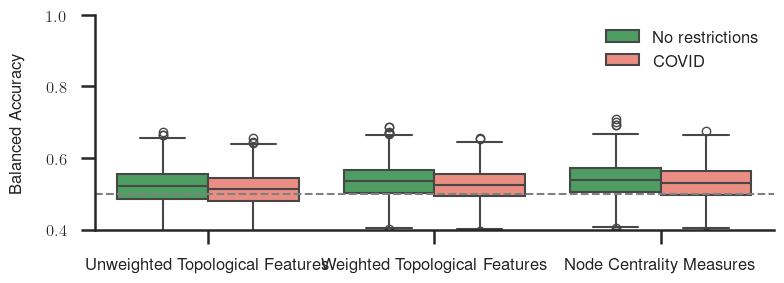

In [51]:
stdrcparams(usetex=True)
df = pd.DataFrame(balanced_acc_non)
models=[ 'Unweighted Topological Features',
         'Weighted Topological Features',
         'Node Centrality Measures'
       ]
xlbls=[ 'Unweighted Topological Features',
         'Weighted Topological Features',
         'Node Centrality Measures'
      ]

df = df[df.Model.isin(models)]
fig,ax = plt.subplots(figsize=(xs,ys*0.6))
ax = sns.boxplot(x="Model", y="Balanced Acc",hue='Time',
                 palette=sns.color_palette(['#41ab5d','#fb8072']),#,'#41ab5d','#e5f5e0']),
                 data=df,ax=ax,linewidth=1.5,
                 hue_order=['No restrictions','COVID'])#,'Non-Simultaneous','Non-Simultaneous Null'])
custom_frame(ax)
plt.ylabel('Balanced Accuracy')
plt.xlabel('')
plt.xticks(range(3),xlbls)
plt.legend(frameon=False)
ax.axhline(y=0.5, linestyle = '--',color ='grey')
plt.ylim(0.4,1)
plt.yticks([0.4,0.6,0.8,1.0])
plt.tight_layout()
plt.show()

## SHAP-values

In [157]:
import shap

def singleShap(test_list, year_list, shap_list):
    year = pd.Period('2024-01', freq='M')  # Adjust to match your year format
    idx = year_list.index(year)
    shap_values = shap_list[idx]
    test_df = test_list[idx]
    
    # Map feature names
    test_df.columns = [feature_name_map.get(col, col) for col in test_df.columns]

    fig, ax = plt.subplots(figsize=(8, 5))
    shap.summary_plot(shap_values, test_df, alpha=0.5, show=False,
                      color_bar=False, auto_size_plot=True, plot_size=(8, 5))
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    labels = [feature_name_map.get(item.get_text(), item.get_text()) for item in ax.get_yticklabels()]
    ax.set_yticklabels(labels)
    ax.set_xlim(-1, 1)
    
    plt.tight_layout()
    plt.show()

In [155]:
with open('/Users/merelkamper/Documents/MSc Data Science/Thesis/MSC_Thesis_code/new_results/NS_Classification_BTF_SHAP.pkl','rb') as f:    
    df_SHAPClassification_BTF = pickle.load(f)
with open('/Users/merelkamper/Documents/MSc Data Science/Thesis/MSC_Thesis_code/new_results/NS_Classification_WTF_SHAP.pkl','rb') as f:    
    df_SHAPClassification_WTF = pickle.load(f)
with open('/Users/merelkamper/Documents/MSc Data Science/Thesis/MSC_Thesis_code/new_results/NS_Classification_NCM_SHAP.pkl','rb') as f:    
    df_SHAPClassification_NCM = pickle.load(f)
    
df_SHAPClassification = {
                        'BTF': df_SHAPClassification_BTF,
                        'WTF': df_SHAPClassification_WTF,
                        'NCM': df_SHAPClassification_NCM}

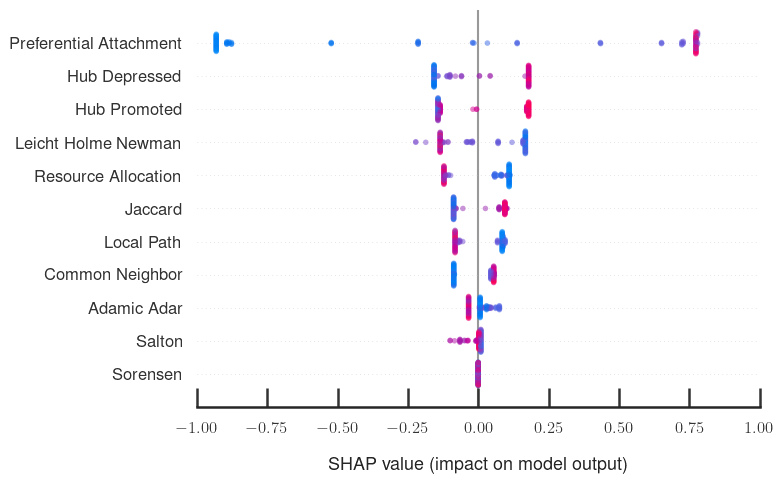

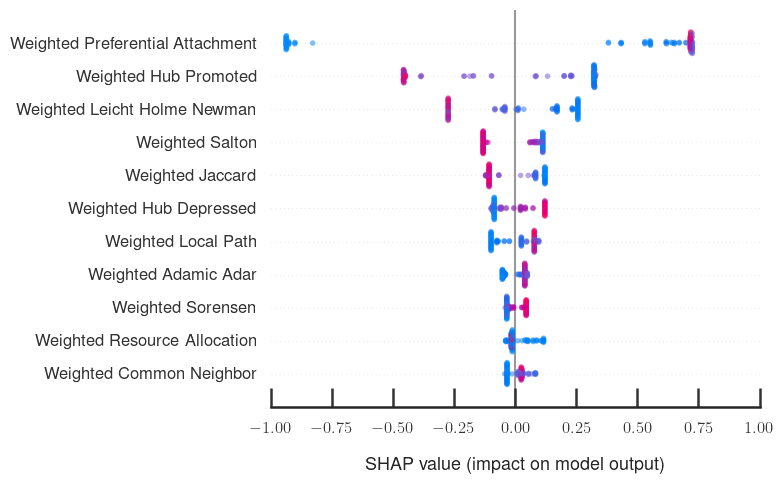

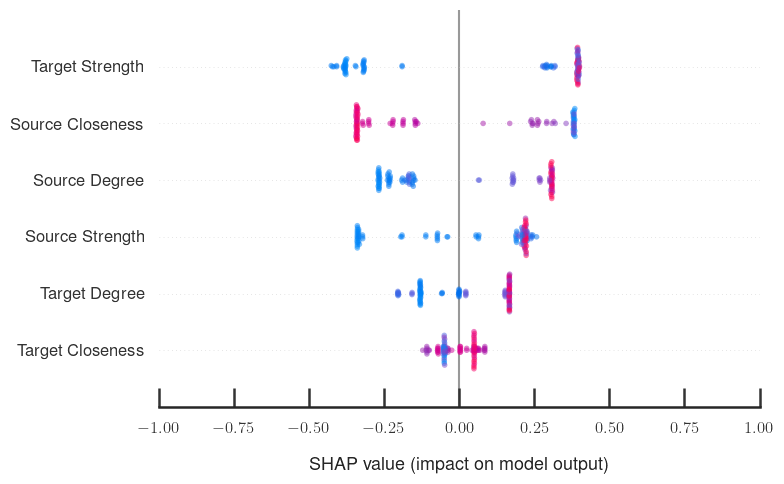

In [158]:
for name, df in df_SHAPClassification.items():
    singleShap(*df)

In [129]:
def get_temporal_order(shap_list):
    importance_array = []
    for shap_values in shap_list: 
        array = -np.abs(shap_values).mean(0)
        order = array.argsort()
        ranks = order.argsort()
        importance_array.append(ranks+1)
    return(np.array(importance_array))

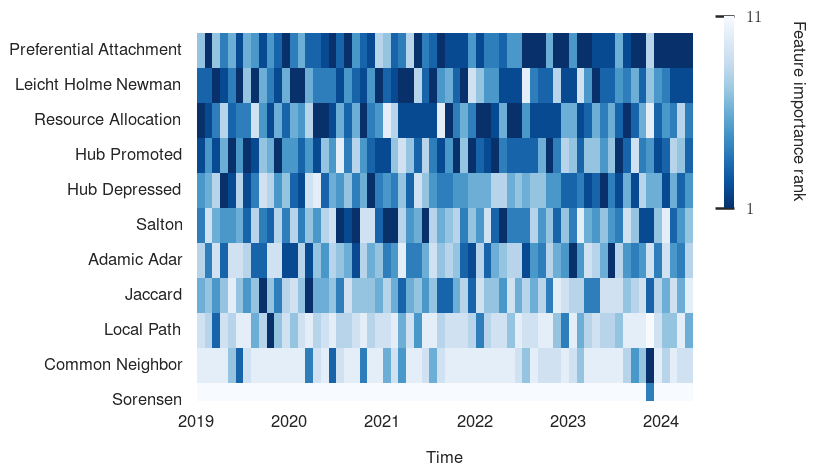

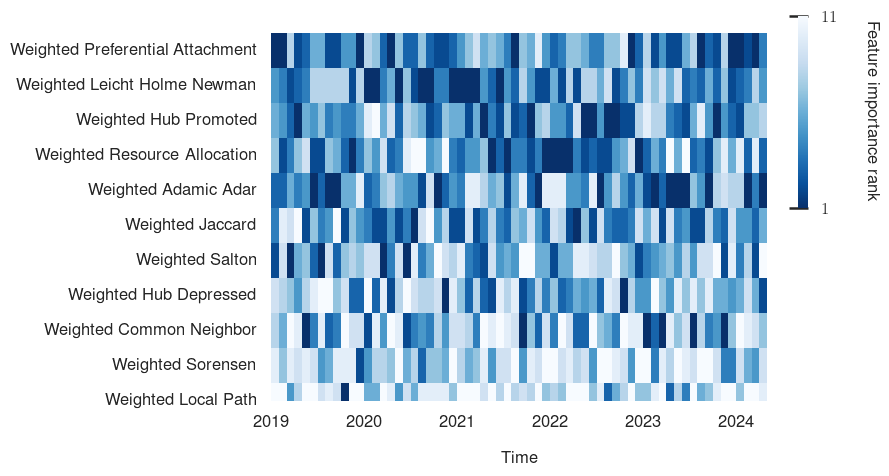

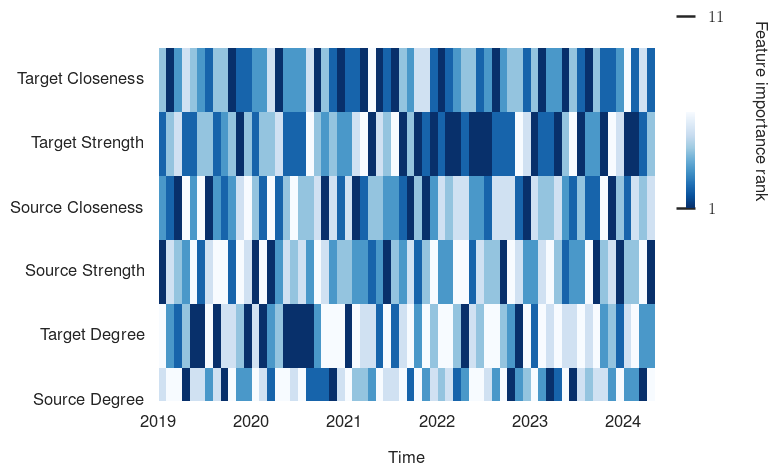

In [140]:
for name, df in df_SHAPClassification.items():
    fig, ax = plt.subplots(figsize=(xs, ys))
    features = list(df[0][0].columns)
    
    importance = get_temporal_order(df[2][0:0+24*8])
    x = [j for _, j in sorted(zip(importance.T.mean(1), importance.T))]
    y = [j for _, j in sorted(zip(importance.T.mean(1), features))]
    
    # Sort the features in the correct order and ensure consistent y-ticks
    sorted_features = sorted(features, key=lambda f: y.index(f))
    sorted_features = [feature_name_map.get(f, f) for f in sorted_features]  # Rename features
    
    ax = sns.heatmap(x,
                     cmap=mpl.cm.get_cmap('Blues_r'),
                     yticklabels=sorted_features,
                     xticklabels=False,
                     cbar_kws={'label': 'Feature importance rank',
                               'ticks': [2, 4, 6, 8, 10] ,
                               'shrink': 0.5,
                               'anchor': (0.0, 1.0)})
    cbar = ax.collections[0].colorbar
    cbar.set_ticks([1, 11])
    cbar.set_label('Feature importance rank', labelpad=30, rotation=360-90)
    plt.ylim(len(features)-0.5, -0.5)  # Adjust y-axis limits based on the number of features

    # Set the xticks for the years from 2019 to 2024
    num_months = (2024 - 2019) * 12  # Total number of months from 2019 to 2024
    plt.xticks([12 * i for i in range(num_months // 12 + 1)], 
               [date(2019 + i, 1, 1).year for i in range(num_months // 12 + 1)])

    plt.xlabel('Time')
    ax.tick_params(top=False)  # Remove the lines at the top
    ax.tick_params(right=False)  # Remove the lines at the top


    # Rotate the y-tick labels to horizontal if the features are unweighted topological features
    if "Unweighted" in name:
        ax.yaxis.set_tick_params(rotation=0)

    plt.show()